In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read data

In [329]:
wide_info_auto = pd.read_csv('/home/mam_jupyter/jupyter_dir/artefact/leads_scoring_model/wide_info_auto.csv', delimiter = ',', index_col = 0)

In [284]:
feature_list = pd.read_csv('feature_list.csv',index_col = 1)

In [332]:
#deal rate
float(len(wide_info_auto[wide_info_auto['d_deal_flag']==1]))/float(len(wide_info_auto))

0.12334980955785374

### Drop low cov cols and unwanted cols

In [285]:
wide_info_auto['mobile']=wide_info_auto['mobile'].apply(lambda x:str(x))

In [286]:
col_drop_df =pd.read_csv('autohome_drop_low_cov.csv',index_col = 0)
col_drop = col_drop_df.index.to_list()
col_drop.extend(['h_goal','h_models','h_client_focus'])

In [287]:
wide_info_auto = wide_info_auto.drop(col_drop,axis = 1)

In [288]:
df = wide_info_auto

### Built functions

In [289]:
# transform date difference into binary values indicating having value or not
def get_binary_cat(df,col):
    '''
    Create binary column with 1 indicting not null and 0 indicating null given:
    df(dataframe): input dataframe
    col: column used to transfer
    '''
    index_list = df[df[col].isnull()==False].index
    df.loc[index_list,col] = 1
    df.loc[~df.index.isin(index_list),col] = 0
    return df[col]

In [290]:
def multi_class(df,col,bins):
    '''
    Create multiple-class column by cutting column from bins given:
    df(dataframe): input dataframe
    col: column used to transfer
    bins: bins used to cut column
    '''
    table = df[(df[col].isnull()==False)]
    bins.append(table[col].max())
    bins.append(table[col].min())
    bins = list(set(bins))
    bins.sort()
    df[col]=pd.cut(table[col],bins = bins)
    return df[col]

In [291]:
def compute_lift_matrix(df, action_col, conv_col,interval = True):
    '''
    Functions that compute a lift matrix given:
    df (dataframe): input dataframe (ex: transaction table)
    conv_col (string): column name of the dataframe containing the purchase indicator
    action_col (list of string): list of column name of the dataframe containing the actions
    interval (bool): bool value with True indicating the action_col values are intervals and False for indipendent values(float/int)
    '''
    list_conversion = list(df[conv_col].unique()) #upper row in the matrix
    list_conversion = [x for x in list_conversion if x is not None] #delete potential None value
    lift_matrix_to_df = [] #list of lists from which we create the lift matrix
    action_index = [] #future indexes of the lift matrix
    action_origin_index = []
    
    def compute_prob_cond(df, conv_col, conversion_item, action, action_instance):
        prob_cond = float(df[(df[conv_col] == conversion_item) & \
                       (df[action] == action_instance)]["mobile"].unique().shape[0])/float(df[df[action] == action_instance]["mobile"].unique().shape[0])
        return prob_cond

    def compute_prob_conv(df, conv_col, conversion_item):
        prob_conv = float(df[df[conv_col] == conversion_item]["mobile"].unique().shape[0])/float(df["mobile"].unique().shape[0])
        return prob_conv

    def compute_lift(prob_cond, prob_conv):
        return prob_cond/prob_conv
    
    #We iterate over the different action columns we want to see in the lift matrix
    for action in action_col:
        list_actions = list(df[df[action].isnull()==False][action].unique()) #left column in the matrix
        if len(list_actions) > 15:
            print(action,len(list_actions))
        list_actions_origin = [x for x in list_actions if (x is not None)&(x != np.nan)] #delete potential None value
        list_actions= []
        for action_instance in list_actions_origin:
            #if df[(df[action] == action_instance)&(df['d_deal_flag']==1)]["mobile"].unique().shape[0]>=len(df[(df[action].isnull()==False)&(df['d_deal_flag']==1)])*0.01:
            list_actions.append(action_instance)
        action_list_name = [a for a in list_actions]
        action_index = action_index + action_list_name #names of the actions that will appear on the lift matrix
        action_origin = [str(action)]*len(list_actions)
        action_origin_index = action_origin_index + action_origin
        for action_instance in list_actions:
            lift_row = [] #row with lifts, row to be added successively to the matrix 
            for conversion_item in list_conversion:
                try:
                    prob_cond = compute_prob_cond(df, conv_col, conversion_item, action, action_instance)
                    prob_conv = compute_prob_conv(df, conv_col, conversion_item)
                    prob_cond = compute_lift(prob_cond, prob_conv)
                except ZeroDivisionError:
                    prob_cond = "NA"
                lift_row.append(prob_cond)
            lift_row.append(df[df[action] == action_instance]["mobile"].unique().shape[0]) # add total population
            lift_matrix_to_df.append(lift_row)
        # create the lift matrix
        lift_matrix = pd.DataFrame(lift_matrix_to_df, columns = list_conversion + ['Total action population'])
        lift_matrix["action"] = action_index
        lift_matrix['action_origin']= action_origin_index
        if interval == True:
            lift_matrix['right'] = lift_matrix["action"].apply(lambda x:x.right)
        lift_matrix = lift_matrix.set_index("action", drop = True)
    
    return lift_matrix

In [292]:
def plot_matrix(lift_matrix, col,sort_by_val):
    '''
    Plot matrix from lift_matrix result given:
    lift_matrix (dataframe): input lift_matrix
    col (string): column name of action
    sort_by_val(string/None): column name used to sort the lift matrix, if None then do not sort
    '''
    matrix = lift_matrix[lift_matrix['action_origin']==col]
    if sort_by_val is not None:
        matrix = matrix.sort_values(by=sort_by_val,ascending=True)
    else:
        pass
    #comment = matrix['comment'].iloc[0]
    plt.figure(figsize=(10, 25))
    plt.subplot(411)
    sns.barplot( x = matrix.index, y = matrix.columns[1], data = matrix, \
               palette = sns.diverging_palette(220, 20, n = 5)).set_title(col)
    plt.legend(loc = 1)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')

In [293]:
def cols_to_multi_class(df,col_lst,bins_lst,binary = False):
    '''
    Transfer columns in list into multiple classes or binary classes given:
    df(dataframe): input dataframe
    col_lst(string): list of column name of the dataframe containing the actions
    bins_lst(string/None): list of bins used to cut each column
    binary(bool): bool calue indicating whether to transfer into binary classes or multiple classes
    '''
    if binary == False:
        for i in range(len(col_lst)):
            col = col_lst[i]
            bins = bins_lst[i]
            df[col] = multi_class(df,col,bins)
    else:
        for col in col_lst:
            df[col] = get_binary_cat(df,col)
  
    return df

def plot_lift_matrix(df,col_lst,interval = True,sort_by_val = 'action'):
    '''
    Compute lift matrix of given columns and Plot matrix from lift_matrix result given:
    df(dataframe): input dataframe
    col_lst(string): list of column name of the dataframe containing the actions
    interval (bool): bool value with True indicating the action_col values are intervals and False for indipendent values(float/int)
    sort_by_val(string/None): column name used to sort the lift matrix, if None then do not sort
    '''
    lift_matrix = compute_lift_matrix(df, col_lst, 'd_deal_flag',interval = interval )
    lift_matrix = lift_matrix.merge(feature_list['comment'],how='left',left_on = 'action_origin',right_index = True)
    action_o = lift_matrix['action_origin'].unique()
    for col in action_o:
        plot_matrix(lift_matrix, col,sort_by_val)

### Transform columns

##### datetime

###### -1, datetime to week and month

In [294]:
# transform datetime data
datetime_list = ['d_fir_leads_time', 'd_fir_card_time', 'd_fir_visit_time', 'd_fir_trail', 'd_last_reservation_time','d_fir_dealfail_d',
                 'd_last_dealfail_d', 'd_fir_activity_time']

def datatime_to_weekday_and_month(data, col,col_wk_lst,col_mon_lst):
    '''
    
    '''

    data[col] = pd.to_datetime(data[col])
    col_name_wk = col + '_weekday'
    col_wk_lst.append(col_name_wk)
    data[col_name_wk] = [i.isoweekday() if i is not None else np.na for i in data[col]]
    col_name_mon = col + '_month'
    data[col_name_mon] = data[col].dt.month
    col_mon_lst.append(col_name_mon)
    return data,col_wk_lst,col_mon_lst

In [295]:
col_wk_lst = []
col_mon_lst = []
for col in datetime_list:
    df,col_wk_lst,col_mon_lst = datatime_to_weekday_and_month(df, col,col_wk_lst,col_mon_lst)

###### -2.datetime to binary indicating exists or not

In [296]:
datetime_list_bi = ['d_fir_leads_time_weekday',
 'd_fir_card_time_weekday',
 'd_fir_trail_weekday',
 'd_last_reservation_time_weekday',
 'd_fir_dealfail_d_weekday']

In [297]:
df = cols_to_multi_class(df,datetime_list_bi,datetime_list_bi,binary = True)

In [298]:
#plot_lift_matrix(df,datetime_list_bi,interval = False,sort_by_val = None)

###### -3.datetime to multi class

In [299]:
def cols_to_multi_value(df,col_lst,dic_lst):
    '''
    
    '''
    for i in range(len(col_lst)):
        #print i
        dic_for_col = {}
        col = col_lst[i]
        dic = dic_lst[i]
        for k in range(len(dic)):
            for j in dic[k]:
                dic_for_col[j]=k+1
        df[col] = df[col].apply(lambda x: dic_for_col[x] if x>=0 else np.nan)
    return df

In [300]:
datetime_list_multi = ['d_fir_visit_time_weekday',
 'd_last_dealfail_d_weekday',
 'd_fir_leads_time_month',
 'd_fir_card_time_month',
 'd_fir_visit_time_month',
 'd_fir_trail_month',
 'd_last_reservation_time_month',
 'd_fir_dealfail_d_month',
 'd_last_dealfail_d_month',
 'd_fir_activity_time_month']

In [301]:
dic_lst = [[[1,2,3,4,5],[6],[7]],
[[1,2,3,4,5],[6],[7]], 
[[2],[1,3,6,7,8],[5,9,10],[11],[4,12]],
[[2],[1,3,6,7,8],[5,9,10],[11],[4,12]],
[[5,7,8],[2,3,6,9,10,11,12],[1,4]],
[[4,5,7],[2,3,6],[8],[9,11],[10],[12],[1]],
[[2,3,7,8,9],[1,4,5,6,10,11,12]],
[[2,3],[4,7,8],[1,5,6,9,10,11,12]],
[[3,6,7,8,9],[1,2,4,10,11],[5,12]],
[[4,5],[2,3,6,7,8],[1,9,10,11],[12]]
]

In [302]:
df = cols_to_multi_value(df,datetime_list_multi,dic_lst)

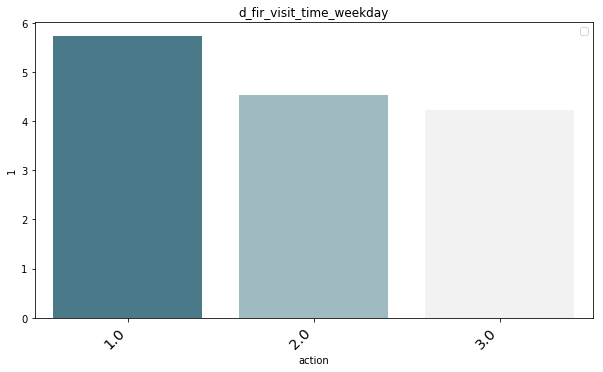

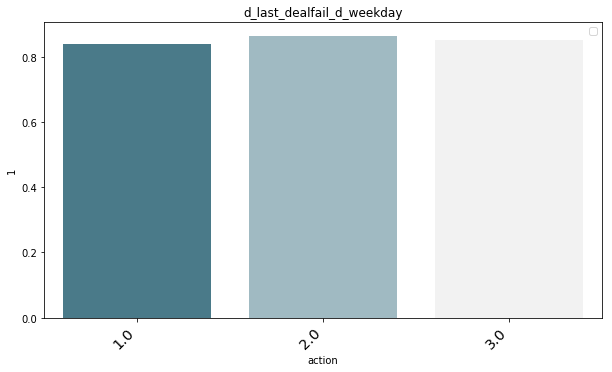

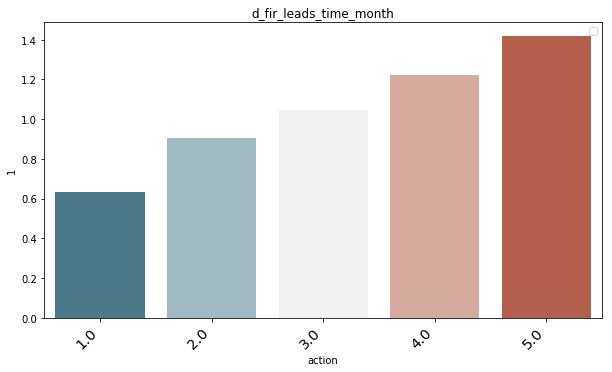

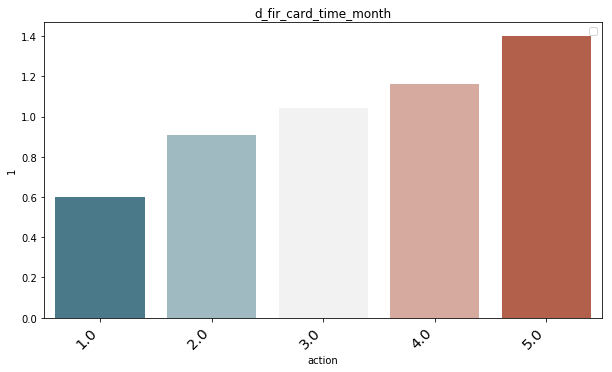

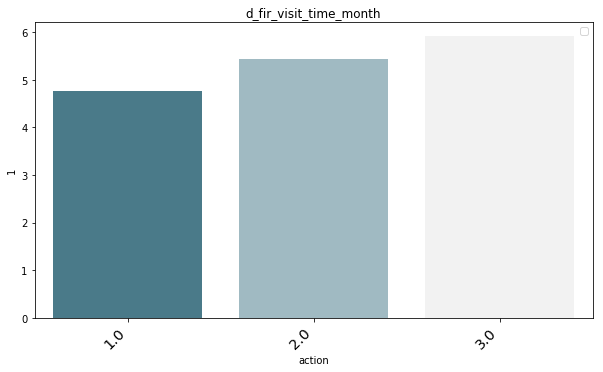

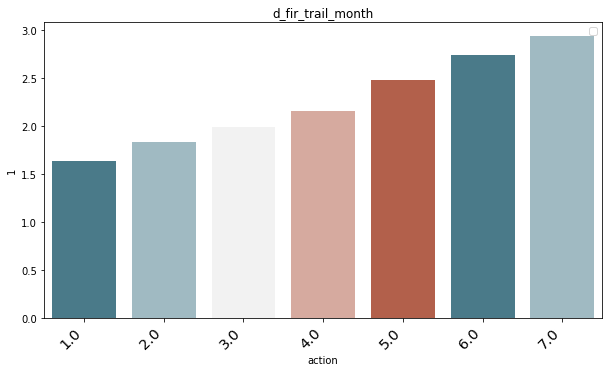

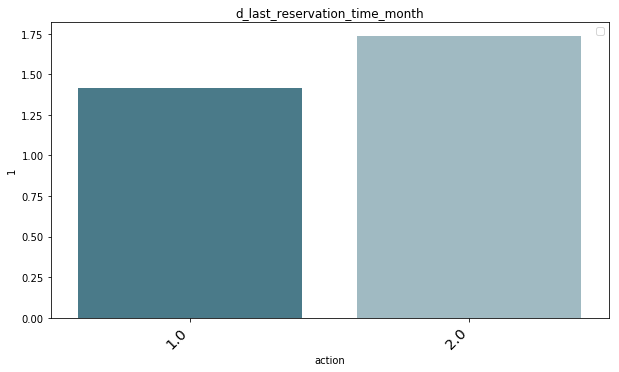

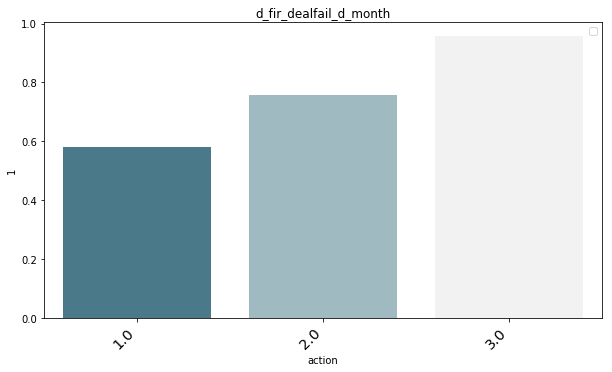

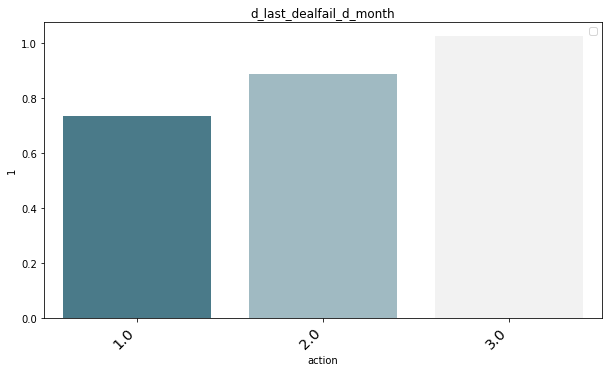

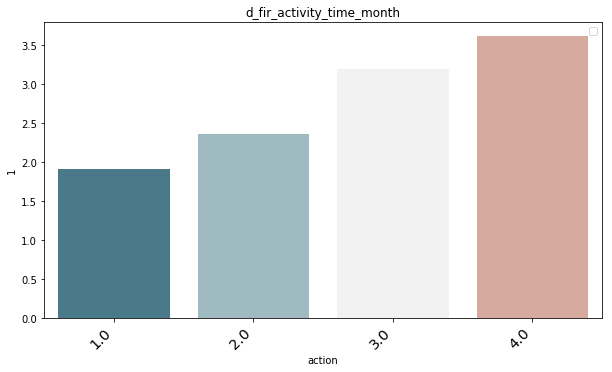

In [247]:
plot_lift_matrix(df,datetime_list_multi,interval = False,sort_by_val = None)

##### age to age interval

In [303]:
def string_to_list_age(x):
    '''
    Ignore multiple ages
    x(string): input string-type list
    '''
    if isinstance(x,str):
        if '|' in x:
            return np.nan
        elif len(x) == 0:
            return np.nan
        else:
            return x
    else:

        return np.nan

col = 'c_age'
df[col] = df[col].apply(string_to_list_age)

age_dic = {}

age_dic['20岁以下'] = pd.Interval(left=0, right=20)
age_dic['21-25岁'] = pd.Interval(left=20, right=25)
age_dic['26-30岁'] = pd.Interval(left=25, right=30)
age_dic['31-35岁'] = pd.Interval(left=30, right=35)
age_dic['36-40岁'] = pd.Interval(left=35, right=60)
age_dic['41-45岁'] = pd.Interval(left=35, right=60)
age_dic['46-50岁'] = pd.Interval(left=35, right=60)
age_dic['51-55岁'] = pd.Interval(left=35, right=60)
age_dic['56-60岁'] = pd.Interval(left=35, right=60)
age_dic['60岁以上'] = pd.Interval(left=60, right=100)

df[col] = df[col].apply(lambda x: age_dic[x] if isinstance(x,str) else np.nan)
lift_matrix = compute_lift_matrix(df, ['c_age'], 'd_deal_flag')
#plot_lift_matrix(df,['c_age'],interval = True,sort_by_val = 'right')

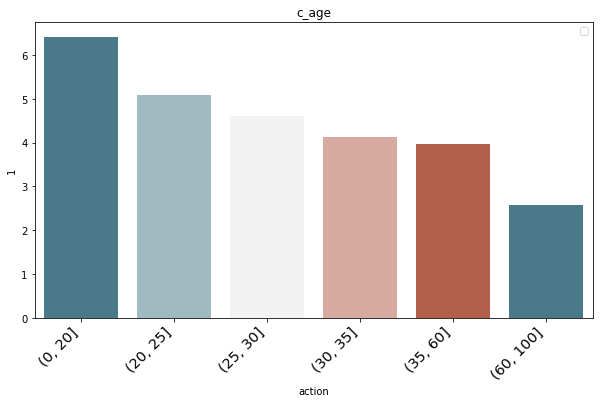

In [217]:
plot_lift_matrix(df,['c_age'],interval = True,sort_by_val = 'right')

##### continuous values to multi class

In [305]:
cols_to_multi = ["d_fir_sec_leads_diff",
"d_avg_leads_date",
"d_avg_visit_date",
"d_avg_fircard_firvisit_diff",
"d_firleads_firvisit_diff",
"d_fircard_firvisit_diff",
"d_avg_firleads_firvisit_diff",
"d_last_dfail_dealf_diff",
"d_dealf_lastvisit_diff", 
"d_firlead_dealf_diff",
"d_lastlead_dealf_diff",
"d_dealf_firvisit_diff",
"d_lasttrail_dealf_diff",
"d_last_activity_dealf_diff",
"d_fir_activity_dealf_diff",
"d_leads_dtbt_coincide",
"d_leads_dtbt_ppt",
"d_deal_fail_ppt",
"h_focusing_avg_diff",
"h_focusing_max_diff",
"d_leads_dtbt_count",
"d_leads_dtbt_level_1",
"d_leads_count",
"d_trail_book_tll",                
"h_model_nums",
"d_visit_ttl",
"d_followup_ttl",
"d_activity_ttl",
"h_max_inquiry_time",
"h_ttl_inquiry_time",
"d_card_ttl"
]

In [306]:
bins_for_multi = [
[-0.000001,0],
[-0.000001,0],
[-0.000001,0],
[-0.000001,0],
[-0.000001,0],
[-0.000001,0],    
[-0.000001,0],
[-0.000001,0],
[-0.000001,0],
[-0.000001,0,1,2,3,4,5,6,7,8,9,10,30],
[-0.000001,0,1,2,3,4,5,6,7,8,9,10,30],
[-0.000001,0,2,3,10,30],
[-0.000001,0,1,2,3,4,6,7,8,9,10,30],
[-0.000001,0,1,2,3,4,6,8,9,10,30],
[-0.000001,0,1,2,3,4,6,8,9,10,30],
[-0.000001,0,0.5,0.8,0.9,1],
[-0.000001,0,0.1,0.2,0.3,0.5,0.7,1,9],
[-0.000001,0,0.9,1],
[-100.000001,-100,-90,-0.000001,60,80,100],
[-100.000001,-100,-90,-0.000001,20,40],
[-0.000001,0,1,2,3,4,5,6,7,8,9,10,20],
[-0.000001,0,1,2,3,4,5,6,7,8,9,10,20],
[-0.000001,0,1,2,3,4,5,6,7,8,9,10,20,50,100],
[-0.000001,10],
[-0.000001,0,1,6],
[-0.000001,0,1],
[-0.000001,0,1],
[-0.000001,0,1],
[-0.000001,0],
[-0.000001,0,1,2,3,4,5],
[-0.000001,0,1,2,3,4,5,6,7,8,9,10]]

In [307]:
df = cols_to_multi_class(df,cols_to_multi,bins_for_multi,binary = False)

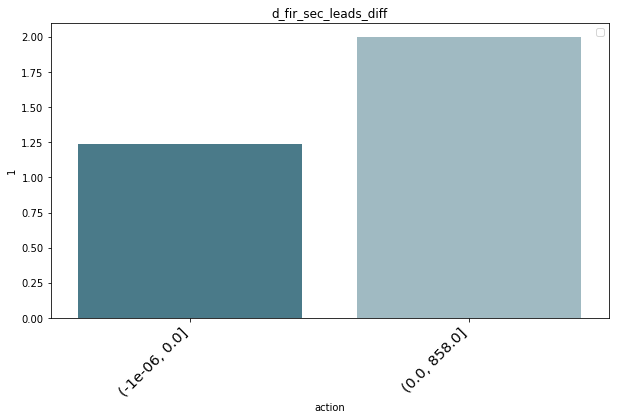

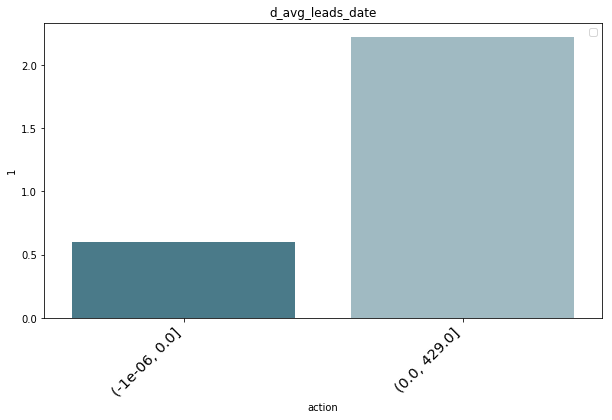

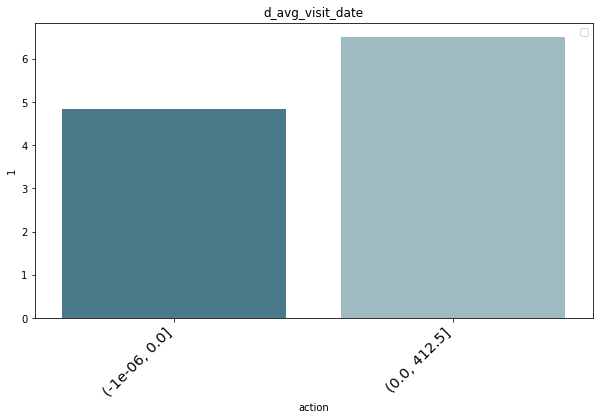

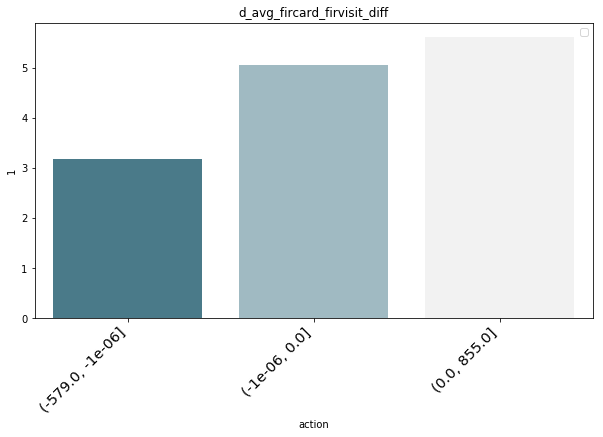

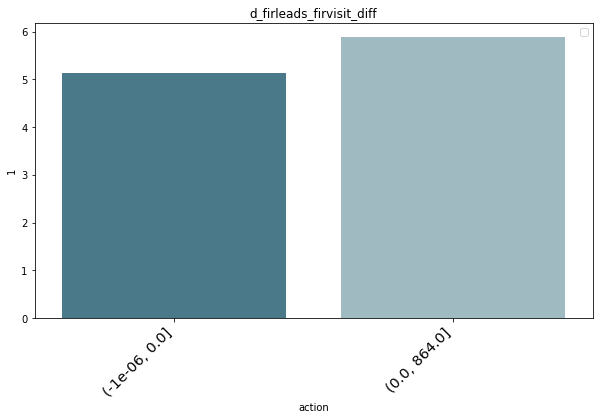

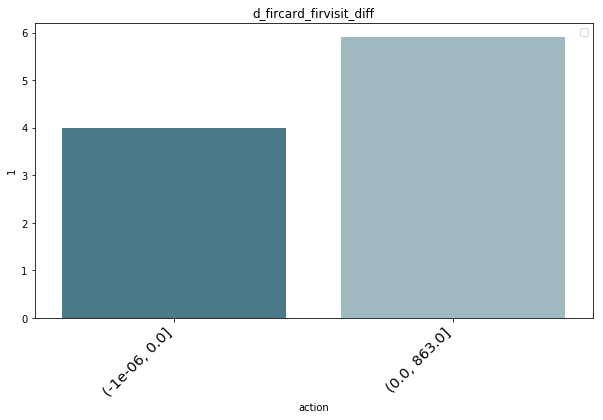

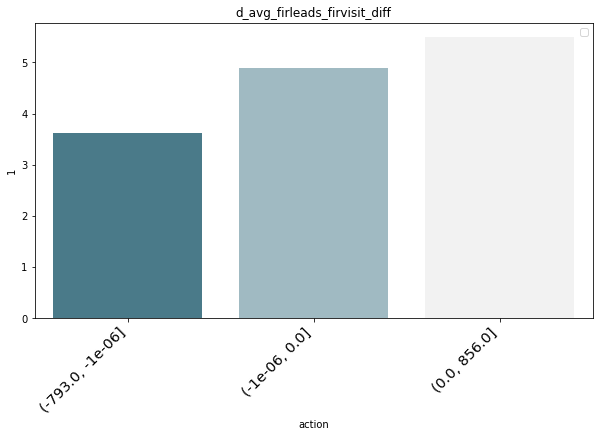

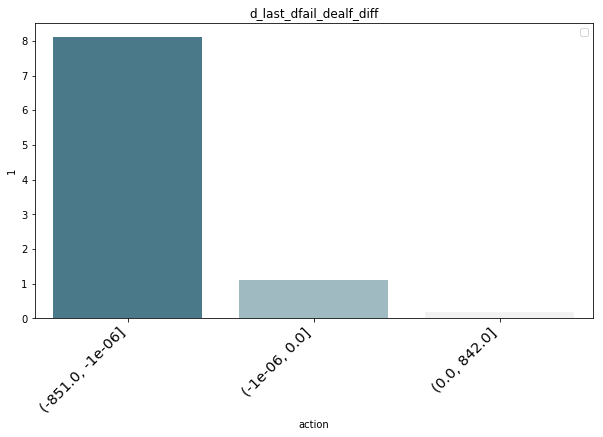

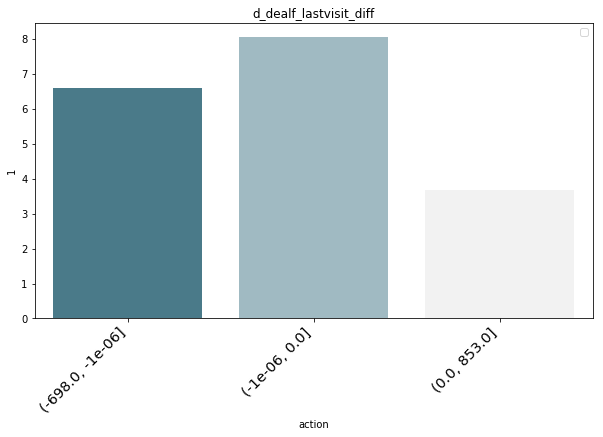

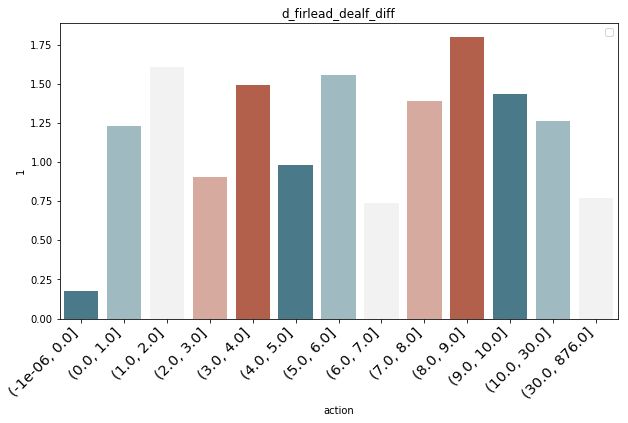

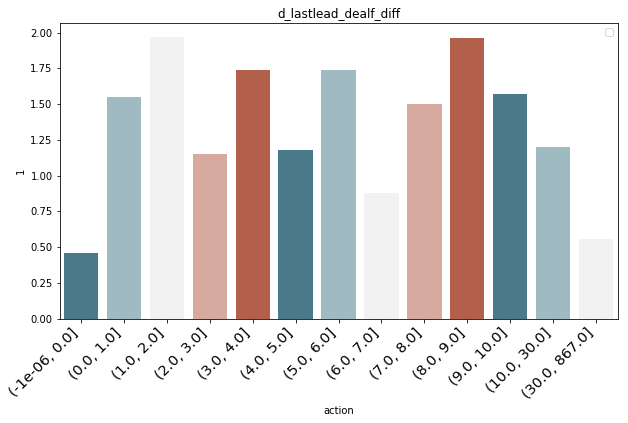

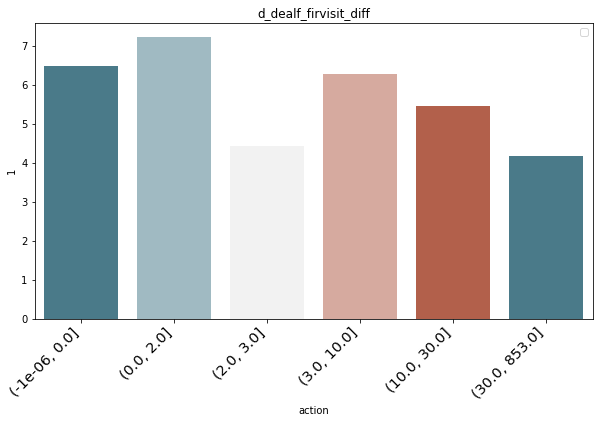

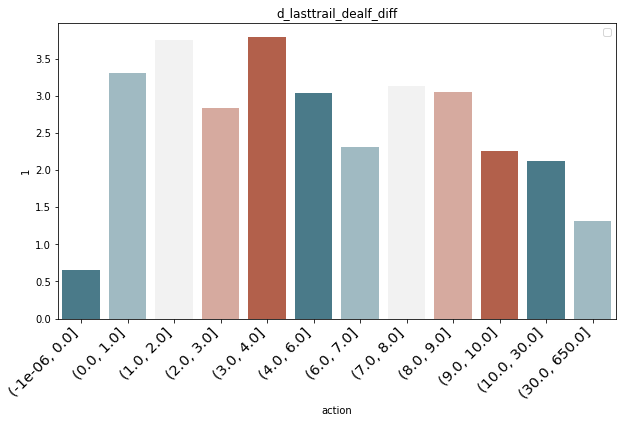

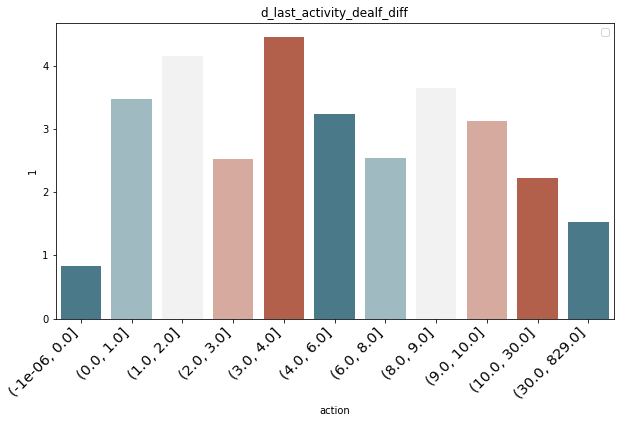

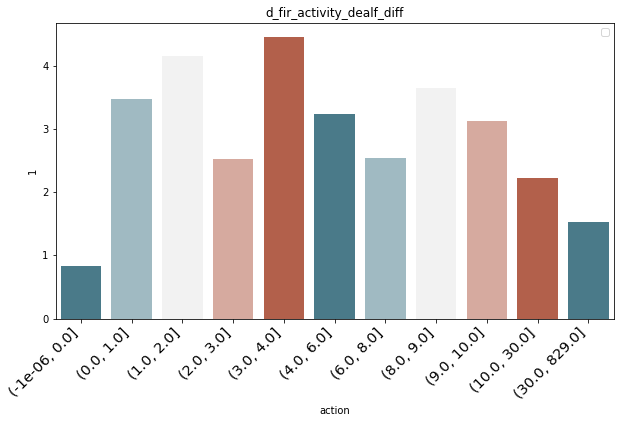

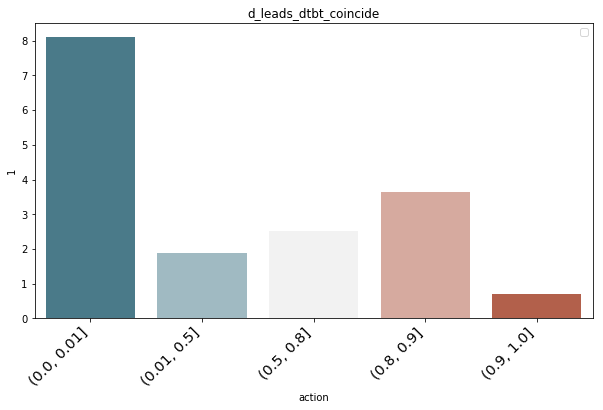

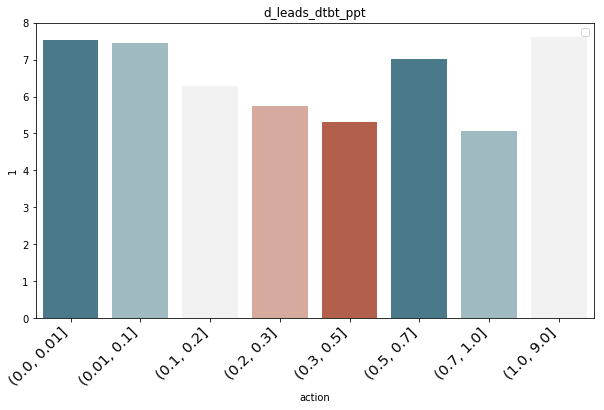

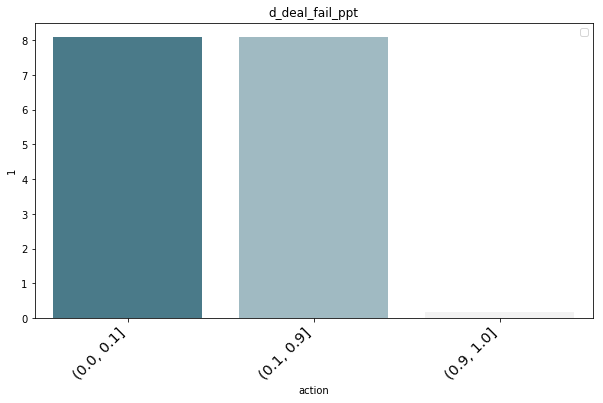

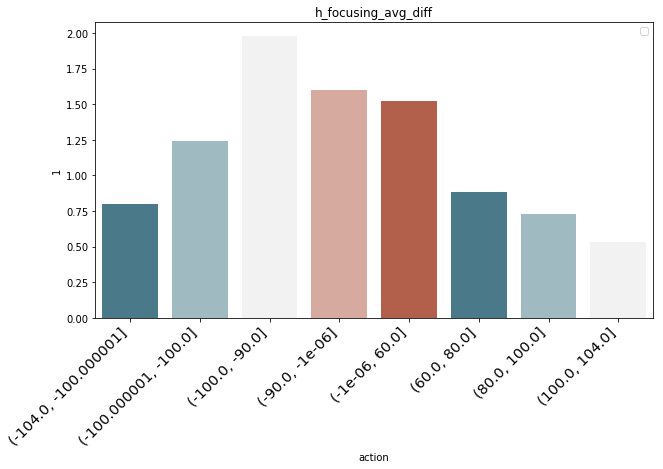

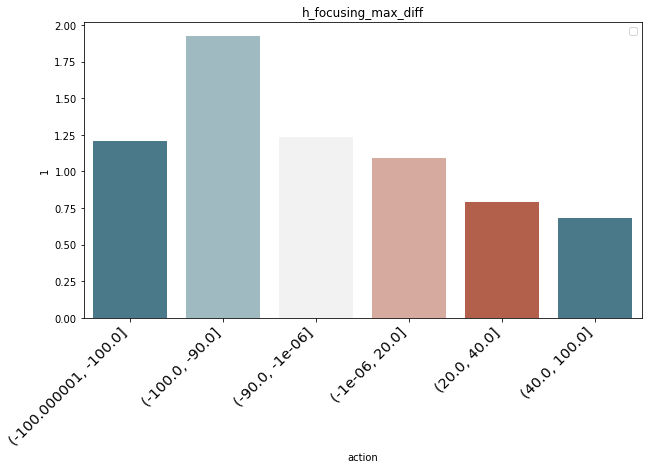

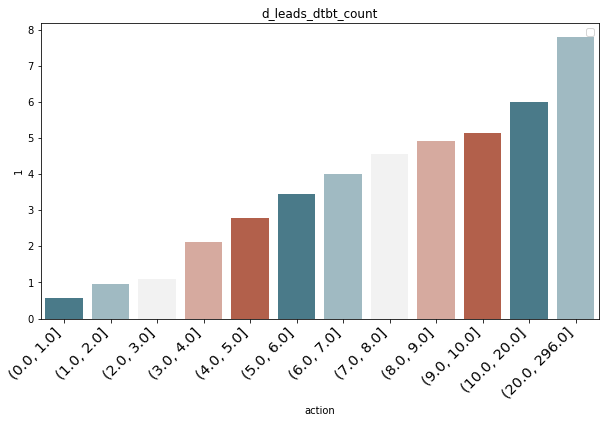

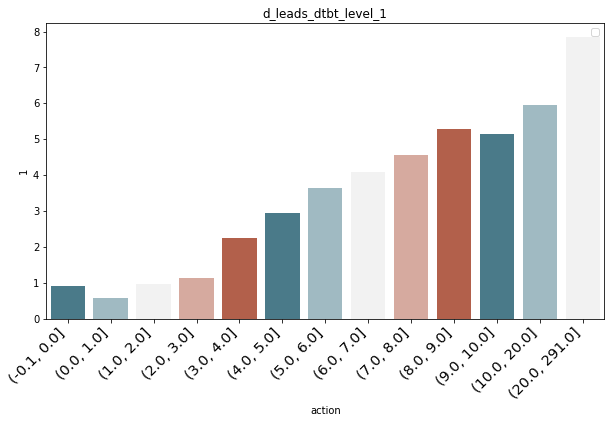

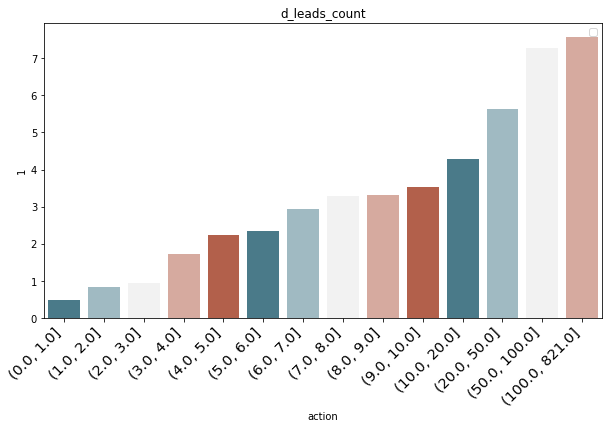

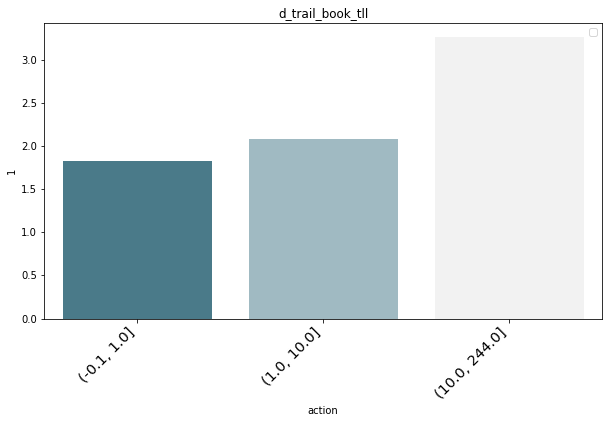

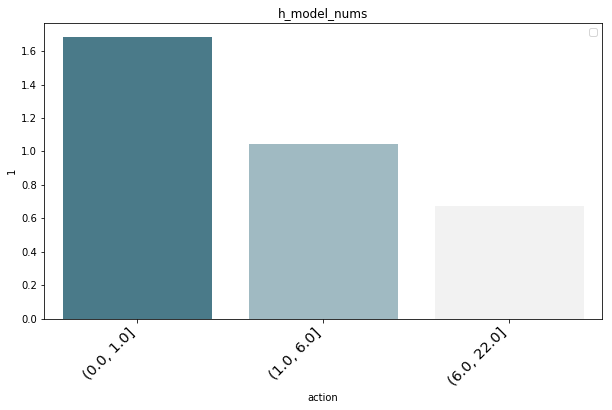

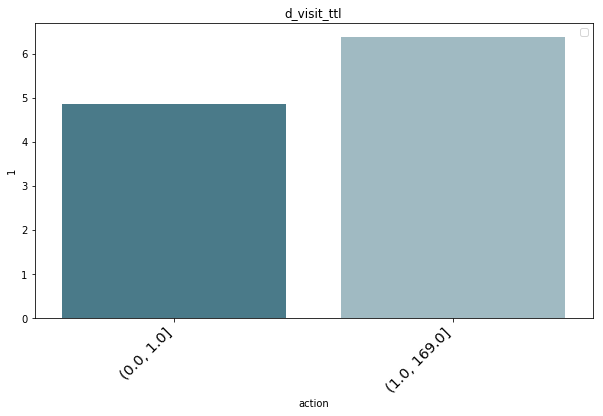

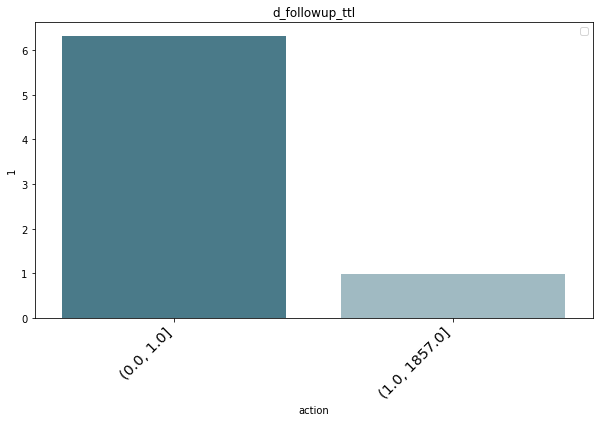

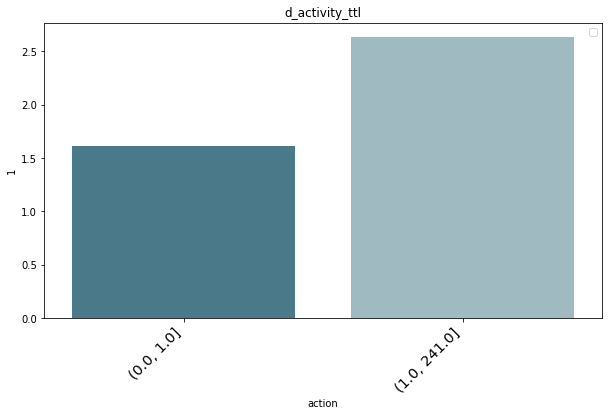

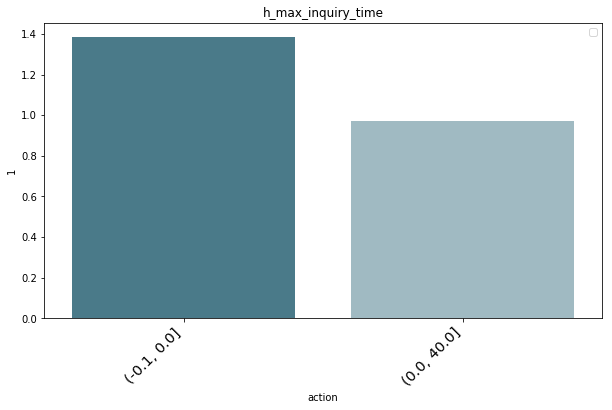

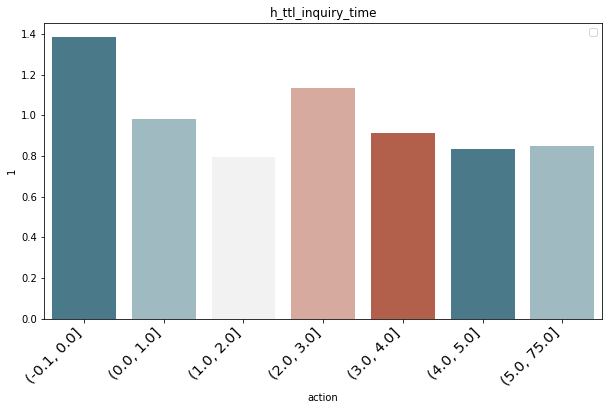

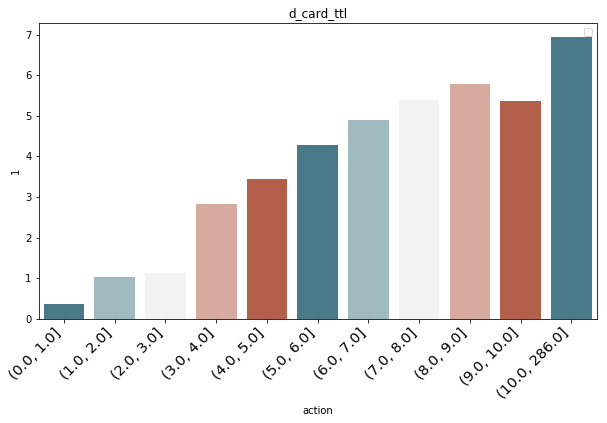

In [249]:
plot_lift_matrix(df,cols_to_multi,interval = True,sort_by_val = 'right')

##### continuous values to binary class

In [308]:
def plot_matrix(lift_matrix, col,sort_by_val):
    '''
    
    '''
    matrix = lift_matrix[lift_matrix['action_origin']==col]
    if sort_by_val is not None:
        matrix = matrix.sort_values(by=sort_by_val,ascending=True)
    else:
        pass
    #comment = matrix['comment'].iloc[0]
    plt.figure(figsize=(10, 25))
    plt.subplot(411)
    sns.barplot( x = matrix.index, y = matrix.columns[1], data = matrix, \
               palette = sns.diverging_palette(220, 20, n = 5)).set_title(col)
    plt.legend(loc = 1)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')

In [309]:
def cols_to_multi_class(df,col_lst,bins_lst,binary = False):
    '''
    
    '''
    if binary == False:
        for i in range(len(col_lst)):
            col = col_lst[i]
            bins = bins_lst[i]
            df[col] = multi_class(df,col,bins)
    else:
        for col in col_lst:
            df[col] = get_binary_cat(df,col)
  
    return df

def plot_lift_matrix(df,col_lst,interval = True,sort_by_val = 'action'):
    '''
    
    '''
    lift_matrix = compute_lift_matrix(df, col_lst, 'd_deal_flag',interval = interval )
    lift_matrix = lift_matrix.merge(feature_list['comment'],how='left',left_on = 'action_origin',right_index = True)
    action_o = lift_matrix['action_origin'].unique()
    for col in action_o:
        plot_matrix(lift_matrix, col,sort_by_val)

In [310]:
cols_to_bi = [
"d_fir_leads_deal_diff_y",
"d_avg_visit_dtbt_count"
]

In [311]:
df = cols_to_multi_class(df,cols_to_bi,None,binary = True)

In [312]:
#plot_lift_matrix(df,cols_to_bi,interval = False,sort_by_val = None)

In [313]:
conv_col ='d_deal_flag'
lift_matrix_1 = compute_lift_matrix(df, datetime_list_bi, conv_col,interval = False)
lift_matrix_2 = compute_lift_matrix(df, datetime_list_multi, conv_col,interval = False)
lift_matrix_3 = compute_lift_matrix(df, ['c_age'], conv_col,interval = True)
lift_matrix_4 = compute_lift_matrix(df, cols_to_multi, conv_col,interval = True)
lift_matrix_5 = compute_lift_matrix(df, cols_to_bi, conv_col,interval = False)

lift_matrix_lst = [lift_matrix_1,lift_matrix_2,lift_matrix_3,lift_matrix_4,lift_matrix_5]

lift_matrix = pd.DataFrame()
for mx in lift_matrix_lst:
    lift_matrix = lift_matrix.append(mx)

### Select categorical columns

In [314]:
col_con = ["h_budget",
"d_fir_sec_leads_diff",
"d_avg_leads_date",
"d_avg_visit_date",
"d_fircard_firvisit_dtbt_diff",
"d_avg_fircard_firvisit_diff",
"d_avg_firleads_firvisit_diff",
"d_fir_leads_deal_diff_y",
"d_firlead_dealf_diff",
"d_lastlead_dealf_diff",
"d_last_dfail_dealf_diff",
"d_dealf_lastvisit_diff",
"d_dealf_firvisit_diff",
"d_lasttrail_dealf_diff",
"d_firleads_firvisit_diff",
"d_fircard_firvisit_diff",
"d_last_activity_dealf_diff",
"d_fir_activity_dealf_diff",
"d_fir_leads_time",
"d_fir_card_time",
"d_fir_visit_time",
"d_fir_trail",
"d_last_reservation_time",
"d_fir_dealfail_d",
"d_last_dealfail_d",
"d_fir_activity_time",
"d_leads_dtbt_coincide",
"d_leads_dtbt_ppt",
"d_deal_fail_ppt",
"h_focusing_avg_diff",
"h_focusing_max_diff",
"d_leads_dtbt_count",
"d_leads_dtbt_level_1",
"c_age",
"h_model_nums",
"h_budget_min",
"h_budget_max",
"c_city",
"c_province",
"d_leads_count",
"d_card_ttl",
"d_visit_ttl",
"d_avg_visit_dtbt_count",
"d_followup_ttl",
"d_trail_book_tll",
"d_activity_ttl",
"h_ttl_inquiry_time",
"h_max_inquiry_time"]

col_con.extend(col_wk_lst)
col_con.extend(col_mon_lst)

In [315]:
con_cat = df[[e for e in wide_info_auto.columns if e not in col_con]]
action_col = con_cat.drop(['mobile','d_deal_flag'],axis = 1)

In [316]:
lift_matrix_6 = compute_lift_matrix(con_cat,action_col, conv_col,interval = False)

('h_level', 18)


### Conbine lift matrix for transformed features

In [317]:
lift_matrix = lift_matrix.append(lift_matrix_6)

In [318]:
drop_lst = [
"h_budget",
"d_fircard_firvisit_dtbt_diff",
"d_fir_leads_time",
"d_fir_card_time",
"d_fir_visit_time",
"d_fir_trail",
"d_last_reservation_time",
"d_fir_dealfail_d",
"d_last_dealfail_d",
"d_fir_activity_time"
]

In [319]:
lift_matrix[lift_matrix['action_origin'].isin(drop_lst)]

,0,1,Total action population,action_origin,right
action,,,,,


In [325]:
lift_matrix = lift_matrix.merge(feature_list['comment'],how='left',left_on = 'action_origin',right_index = True)

In [326]:
lift_matrix.to_csv('lift_matrix_auto.csv',encoding='utf-8')

In [327]:
lift_matrix.to_excel('lift_matrix_auto.xlsx',encoding='utf-8')

In [328]:
len(lift_matrix)

511

In [ ]:
lift_matrix

### Combine transformed features and delect original features

In [322]:
df = df.drop([
"h_budget",
"d_fircard_firvisit_dtbt_diff",
"d_fir_leads_time",
"d_fir_card_time",
"d_fir_visit_time",
"d_fir_trail",
"d_last_reservation_time",
"d_fir_dealfail_d",
"d_last_dealfail_d",
"d_fir_activity_time"
],axis = 1)

In [323]:
df.to_csv('wide_info_auto_trans.csv',encoding = 'utf-8')